In [23]:
from pathlib import Path
import pandas as pd
df_merged = pd.read_csv(Path('df_merge_final.csv'))

In [4]:
import streamlit as st
import pandas as pd
import pickle

from pathlib import Path

# Cargar los modelos
def load_model(model_path):
    try:
        with open(model_path, 'rb') as file:
            return pickle.load(file)
    except Exception as e:
        st.error(f"Error al cargar el modelo {model_path}: {e}")
        return None

# Cargar el archivo CSV y obtener valores únicos de una columna
@st.cache_data
def load_unique_values(csv_path, column_name):
    try:
        df = pd.read_csv(csv_path)
        return df[column_name].dropna().unique()
    except Exception as e:
        st.error(f"Error al cargar valores únicos de '{column_name}' desde {csv_path}: {e}")
        return []

def get_df_model(df_data, features):
    # Read DataFrames
    df_country_freqs = pd.read_csv("df_country_freqs.csv")
    df_event_location_freq = pd.read_csv("df_event_location_freq.csv")
    df_event_country_freq = pd.read_csv("df_event_country_freq.csv")
    df_types_per_location = pd.read_csv('df_types_per_location.csv')
    df_types_per_location = df_types_per_location.drop(columns=['Unnamed: 0'], errors='ignore')
    df_merge = pd.read_csv("df_merge_final.csv")

    df_country_of_location = df_merge[['EventCountry', 'EventLocation']].drop_duplicates().sort_values('EventCountry')
    df_data['Gender_M'] = df_data['Gender'].replace({"F": 0, "M": 1})
    df_data = pd.merge(df_data, df_country_freqs[['Country', 'Country_Encoded']], on='Country', how='left')
    df_data = pd.merge(df_data, df_event_location_freq[['EventLocation', 'EventLocation_Encoded']], on='EventLocation', how='left')
    df_data['EventCountry'] = df_country_of_location[df_country_of_location['EventLocation'] == event]['EventCountry'].values[0]
    df_data = pd.merge(df_data, df_event_country_freq[['EventCountry', 'EventCountry_Encoded']], on='EventCountry', how='left')

    age_limits = [0, 18, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85]
    age_groups = ['00', '18-24', '25-29', '30-34', '35-39', '40-44', '45-49', '50-54', '55-59', '60-64', '65-69', '70-74', '75-79', '80-84', '85-89']

    def get_age_band_and_group(age):
        age_band = max([limit for limit in age_limits if limit <= age])
        idx = age_limits.index(age_band)
        age_group = age_groups[idx]
        
        return age_band, age_group

    df_data[['AgeBand', 'AgeGroup']] = df_data['Age'].apply(lambda age: pd.Series(get_age_band_and_group(age)))

    df_filter = df_merge[['Country','Location', 'Swim Type', 'Bike Type', 'Run Type', 'Latitude', 'Longitude', 'Altitude (m)', 'Air Temperature (°C)', 'Water Temperature (°C)', 'EventCountry', 'Distance from Country Center (km)', 'Distance from Country Center (m)', 'EventLocation']].drop_duplicates()
    df_model = pd.merge(df_data, df_filter, on=['EventLocation', 'Country', 'EventCountry'], how='inner')
    df_model = pd.merge(df_model, df_types_per_location, on='EventLocation_Encoded', how='inner')
    df_model['Is_Local'] = (df_model['Country'] == df_model['EventCountry']).astype(int)

    return df_model[features]

# Predicción basada en modelos
def predict_time(model, df_data):
    if model is None:
        return "Modelo no disponible"
    try:
        features = model.get_booster().feature_names
        input_data = get_df_model(df_data, features)
        # Realizar predicción
        prediction = model.predict(input_data)
        return round(prediction[0], 2)
    except Exception as e:
        st.error(f"Error al realizar la predicción: {e}")
        return "Error en la predicción"

# Cargar los modelos
model_swim = load_model('model_xgb_swim.pkl')
model_bike = load_model('model_xgb_bike.pkl')
model_run = load_model('model_xgb_run.pkl')

# Configurar la app de Streamlit
st.title("Predicción de tiempos para Ironman 70.3")

# Cargar valores únicos de las columnas requeridas
event_locations = load_unique_values('df_merged_small.csv', 'EventLocation')
genders = load_unique_values('df_merged_small.csv', 'Gender')
countries = load_unique_values('df_merged_small.csv', 'Country')

# # Interfaz de usuario
# st.header("Introduce los detalles")
# age = st.slider("Edad", 18, 70, 30)
# elite = st.checkbox("¿Eres atleta de élite?")
# event = st.selectbox("Carrera", event_locations)
# gender = st.selectbox("Género", genders)
# country = st.selectbox("País", countries)

# if st.button("Predecir tiempos"):
#     st.subheader("Resultados")
#     df_data = pd.DataFrame({'Age': [age], 'Elite': [elite], 'EventLocation': [event], 'Gender': [gender], 'Country': [country]})
#     swim_time = predict_time(model_swim, df_data)
#     bike_time = predict_time(model_bike, df_data)
#     run_time = predict_time(model_run, df_data)

#     st.write(f"*Tiempo natación:* {swim_time} minutos")
#     st.write(f"*Tiempo bicicleta:* {bike_time} minutos")
#     st.write(f"*Tiempo carrera:* {run_time} minutos")


2024-12-11 20:49:45.415 No runtime found, using MemoryCacheStorageManager
2024-12-11 20:49:45.440 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-11 20:49:45.441 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.


In [5]:
age = 27
elite = True
event = "IRONMAN 70.3 Mallorca"
gender = "M"
country = "Spain"

In [6]:
df_event_location_freq = pd.read_csv("df_event_location_freq.csv")
df_event_location_freq

,EventLocation,Frequency,EventLocation_Encoded
0,IRONMAN 70.3 Augusta,23803,0
1,IRONMAN 70.3 Florida,22576,1
2,IRONMAN 70.3 Texas,17168,2
3,IRONMAN 70.3 Eagleman,16618,3
4,IRONMAN 70.3 Mallorca,16307,4
...,...,...,...
63,IRONMAN 70.3 Waco,868,63
64,IRONMAN 70.3 San Juan / Puerto Rico,778,64
65,IRONMAN 70.3 Subic Bay,465,65
66,IRONMAN 70.3 Tallinn,452,66


In [7]:
df_event_country_freq = pd.read_csv("df_event_country_freq.csv")
df_event_country_freq

,EventCountry,Frequency,EventCountry_Encoded
0,United States,167068,0
1,Australia,32332,1
2,Canada,21948,2
3,Mexico,21866,3
4,Spain,19061,4
5,Switzerland,13720,5
6,Brazil,9880,6
7,Poland,9265,7
8,Germany,9067,8
9,France,8757,9


In [9]:
df_merge = pd.read_csv("df_merge_final.csv")

In [10]:
df_country_of_location = df_merge[['EventCountry', 'EventLocation']].drop_duplicates().sort_values('EventCountry')
df_country_of_location

,EventCountry,EventLocation
184,Argentina,IRONMAN 70.3 Buenos Aires
27,Argentina,IRONMAN 70.3 San Juan
3770,Australia,IRONMAN 70.3 Cairns
123,Australia,IRONMAN 70.3 Port Macquarie
400,Australia,IRONMAN 70.3 Geelong
...,...,...
174,United States,IRONMAN 70.3 Maine
181,United States,IRONMAN 70.3 San Juan / Puerto Rico
224,United States,IRONMAN 70.3 Indian Wells La Quinta
7,Uruguay,IRONMAN 70.3 Punta del Este


In [11]:
df_country_of_location[df_country_of_location['EventLocation'] == event]['EventCountry'].values[0]

'Spain'

In [12]:
df_data

,Age,Elite,EventLocation,Gender,Country
0,27,True,IRONMAN 70.3 Mallorca,M,Spain


In [13]:
df_event_country_freq

,EventCountry,Frequency,EventCountry_Encoded
0,United States,167068,0
1,Australia,32332,1
2,Canada,21948,2
3,Mexico,21866,3
4,Spain,19061,4
5,Switzerland,13720,5
6,Brazil,9880,6
7,Poland,9265,7
8,Germany,9067,8
9,France,8757,9


In [14]:
df_data['Gender_M'] = df_data['Gender'].replace({"F": 0, "M": 1})
df_data = pd.merge(df_data, df_country_freqs[['Country', 'Country_Encoded']], on='Country', how='left')
df_data = pd.merge(df_data, df_event_location_freq[['EventLocation', 'EventLocation_Encoded']], on='EventLocation', how='left')
df_data['EventCountry'] = df_country_of_location[df_country_of_location['EventLocation'] == event]['EventCountry'].values[0]
df_data = pd.merge(df_data, df_event_country_freq[['EventCountry', 'EventCountry_Encoded']], on='EventCountry', how='left')


C:\Users\emartin4\AppData\Local\Temp\ipykernel_23852\10572739.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_data['Gender_M'] = df_data['Gender'].replace({"F": 0, "M": 1})


In [15]:
df_data

,Age,Elite,EventLocation,Gender,Country,Gender_M,Country_Encoded,EventLocation_Encoded,EventCountry,EventCountry_Encoded
0,27,True,IRONMAN 70.3 Mallorca,M,Spain,1,18,4,Spain,4


In [16]:
import numpy as np
age_limits = [0, 18, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85]
age_groups = ['00', '18-24', '25-29', '30-34', '35-39', '40-44', '45-49', '50-54', '55-59', '60-64', '65-69', '70-74', '75-79', '80-84', '85-89']

def get_age_band_and_group(age):
    age_band = max([limit for limit in age_limits if limit <= age])
    idx = age_limits.index(age_band)
    age_group = age_groups[idx]
    
    return age_band, age_group

df_data[['AgeBand', 'AgeGroup']] = df_data['Age'].apply(lambda age: pd.Series(get_age_band_and_group(age)))


In [17]:
df_filter = df_merge[['Country','Location', 'Swim Type', 'Bike Type', 'Run Type', 'Latitude', 'Longitude', 'Altitude (m)', 'Air Temperature (°C)', 'Water Temperature (°C)', 'EventCountry', 'Distance from Country Center (km)', 'Distance from Country Center (m)', 'EventLocation']].drop_duplicates()
# df_filter.rename(columns = {'EventLocation': 'EventLocation_Encoded'}, inplace=True)

df_filter

,Country,Location,Swim Type,Bike Type,Run Type,Latitude,Longitude,Altitude (m),Air Temperature (°C),Water Temperature (°C),EventCountry,Distance from Country Center (km),Distance from Country Center (m),EventLocation
0,Andorra,"Victoria, British Columbia",Lake,Rolling,Flat,48.428318,-123.364953,23,18,19,Canada,8579.704532,8.579705e+06,IRONMAN 70.3 Victoria
1,Andorra,"Santa Cruz, California",Ocean,Rolling,Flat,37.050096,-121.990590,11,18,17,United States,9505.490221,9.505490e+06,IRONMAN 70.3 Santa Cruz
2,Andorra,"Galveston, Texas",Ocean,Flat,Rolling,29.387225,-94.992736,2,21,22,United States,8360.097393,8.360097e+06,IRONMAN 70.3 Texas
3,Andorra,"Alcúdia, Mallorca, Spain",Ocean,Hilly,Flat,39.852193,3.118502,10,25,17,Spain,325.489516,3.254895e+05,IRONMAN 70.3 Mallorca
4,Andorra,"Vichy, France",Lake,Hilly,Flat,46.123927,3.420371,252,28,25,France,424.510467,4.245105e+05,IRONMAN 70.3 Vichy
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
383489,Zimbabwe,"Panama City Beach, Florida",Ocean,Flat,Flat,30.176591,-85.805386,2,26,22,United States,13442.355752,1.344236e+07,IRONMAN 70.3 Gulf Coast
383490,Zimbabwe,"Chattanooga, Tennessee",River,Rolling,Rolling,35.045722,-85.309488,210,22,22,United States,13424.475251,1.342448e+07,IRONMAN 70.3 Chattanooga
383498,Zimbabwe,"Boise, Idaho",Reservoir,Rolling,Flat,43.616616,-116.200886,820,27,22,United States,15785.331772,1.578533e+07,IRONMAN 70.3 Boise
383499,Zimbabwe,"San Juan, Argentina",Reservoir,Hilly,Flat,-30.705436,-69.198822,598,25,20,Argentina,9800.804073,9.800804e+06,IRONMAN 70.3 San Juan


In [18]:
df_data

,Age,Elite,EventLocation,Gender,Country,Gender_M,Country_Encoded,EventLocation_Encoded,EventCountry,EventCountry_Encoded,AgeBand,AgeGroup
0,27,True,IRONMAN 70.3 Mallorca,M,Spain,1,18,4,Spain,4,25,25-29


In [24]:
df_model = pd.merge(df_data, df_filter, on=['EventLocation', 'Country', 'EventCountry'], how='inner')
df_model

,Age,Elite,EventLocation,Gender,Country,Gender_M,Country_Encoded,EventLocation_Encoded,EventCountry,EventCountry_Encoded,...,Swim Type,Bike Type,Run Type,Latitude,Longitude,Altitude (m),Air Temperature (°C),Water Temperature (°C),Distance from Country Center (km),Distance from Country Center (m)
0,27,True,IRONMAN 70.3 Mallorca,M,Spain,1,18,4,Spain,4,...,Ocean,Hilly,Flat,39.852193,3.118502,10,25,17,685.751053,685751.052848


In [25]:
df_types_per_location = pd.read_csv('df_types_per_location.csv')
df_types_per_location = df_types_per_location.drop(columns=['Unnamed: 0'], errors='ignore')
df_types_per_location

,EventLocation_Encoded,Run Type_Flat,Run Type_Hilly,Run Type_Rolling,Swim Type_Bay,Swim Type_Lake,Swim Type_Ocean,Swim Type_Reservoir,Swim Type_River,Bike Type_Flat,Bike Type_Hilly,Bike Type_Rolling
0,0,1,0,0,0,0,0,0,1,0,0,1
1,1,0,0,1,0,1,0,0,0,0,0,1
2,2,0,0,1,0,0,1,0,0,1,0,0
3,3,1,0,0,0,0,0,0,1,1,0,0
4,4,1,0,0,0,0,1,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...
63,63,0,0,1,0,0,0,0,1,1,0,0
64,64,0,1,0,1,0,0,0,0,1,0,0
65,65,0,0,1,0,0,1,0,0,1,0,0
66,66,1,0,0,1,0,0,0,0,1,0,0


In [26]:
df_model = pd.merge(df_model, df_types_per_location, on='EventLocation_Encoded', how='inner')
df_model

,Age,Elite,EventLocation,Gender,Country,Gender_M,Country_Encoded,EventLocation_Encoded,EventCountry,EventCountry_Encoded,...,Run Type_Hilly,Run Type_Rolling,Swim Type_Bay,Swim Type_Lake,Swim Type_Ocean,Swim Type_Reservoir,Swim Type_River,Bike Type_Flat,Bike Type_Hilly,Bike Type_Rolling
0,27,True,IRONMAN 70.3 Mallorca,M,Spain,1,18,4,Spain,4,...,0,0,0,0,1,0,0,0,1,0


In [32]:
df_model['Is_Local'] = (df_model['Country'] == df_model['EventCountry']).astype(int)
df_model

,Age,Elite,EventLocation,Gender,Country,Gender_M,Country_Encoded,EventLocation_Encoded,EventCountry,EventCountry_Encoded,...,Run Type_Rolling,Swim Type_Bay,Swim Type_Lake,Swim Type_Ocean,Swim Type_Reservoir,Swim Type_River,Bike Type_Flat,Bike Type_Hilly,Bike Type_Rolling,Is_Local
0,27,True,IRONMAN 70.3 Mallorca,M,Spain,1,18,4,Spain,4,...,0,0,0,1,0,0,0,1,0,1


In [16]:
def get_df_model(df_data, features):
    # Read DataFrames
    df_country_freqs = pd.read_csv("df_country_freqs.csv")
    df_event_location_freq = pd.read_csv("df_event_location_freq.csv")
    df_event_country_freq = pd.read_csv("df_event_country_freq.csv")
    df_types_per_location = pd.read_csv('df_types_per_location.csv')
    df_types_per_location = df_types_per_location.drop(columns=['Unnamed: 0'], errors='ignore')
    df_merge = pd.read_csv("df_merge_final.csv")

    df_country_of_location = df_merge[['EventCountry', 'EventLocation']].drop_duplicates().sort_values('EventCountry')
    df_country_of_location[df_country_of_location['EventLocation'] == event]['EventCountry'].values[0]
    df_data['Gender_M'] = df_data['Gender'].replace({"F": 0, "M": 1})
    df_data = pd.merge(df_data, df_country_freqs[['Country', 'Country_Encoded']], on='Country', how='left')
    df_data = pd.merge(df_data, df_event_location_freq[['EventLocation', 'EventLocation_Encoded']], on='EventLocation', how='left')
    df_data['EventCountry'] = df_country_of_location[df_country_of_location['EventLocation'] == event]['EventCountry'].values[0]
    df_data = pd.merge(df_data, df_event_country_freq[['EventCountry', 'EventCountry_Encoded']], on='EventCountry', how='left')

    age_limits = [0, 18, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85]
    age_groups = ['00', '18-24', '25-29', '30-34', '35-39', '40-44', '45-49', '50-54', '55-59', '60-64', '65-69', '70-74', '75-79', '80-84', '85-89']

    def get_age_band_and_group(age):
        age_band = max([limit for limit in age_limits if limit <= age])
        idx = age_limits.index(age_band)
        age_group = age_groups[idx]
        
        return age_band, age_group

    df_data[['AgeBand', 'AgeGroup']] = df_data['Age'].apply(lambda age: pd.Series(get_age_band_and_group(age)))

    df_filter = df_merge[['Country','Location', 'Swim Type', 'Bike Type', 'Run Type', 'Latitude', 'Longitude', 'Altitude (m)', 'Air Temperature (°C)', 'Water Temperature (°C)', 'EventCountry', 'Distance from Country Center (km)', 'Distance from Country Center (m)', 'EventLocation']].drop_duplicates()
    df_model = pd.merge(df_data, df_filter, on=['EventLocation', 'Country', 'EventCountry'], how='inner')
    df_model = pd.merge(df_model, df_types_per_location, on='EventLocation_Encoded', how='inner')
    df_model['Is_Local'] = (df_model['Country'] == df_model['EventCountry']).astype(int)

    return df_model[features]


In [28]:
df_modell = get_df_model(df_data, swim_features)

C:\Users\emartin4\AppData\Local\Temp\ipykernel_11140\1525637845.py:12: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_data['Gender_M'] = df_data['Gender'].replace({"F": 0, "M": 1})


In [4]:
df_model

,Age,Elite,EventLocation,Gender,Country,Gender_M,Country_Encoded,EventLocation_Encoded,EventCountry,EventCountry_Encoded,...,Run Type_Rolling,Swim Type_Bay,Swim Type_Lake,Swim Type_Ocean,Swim Type_Reservoir,Swim Type_River,Bike Type_Flat,Bike Type_Hilly,Bike Type_Rolling,Is_Local
0,27,True,IRONMAN 70.3 Mallorca,M,Spain,1,18,4,Spain,4,...,0,0,0,1,0,0,0,1,0,1


In [7]:
model_xgb_swim = load_model('model_xgb_swim.pkl')

In [8]:
swim_features = model_xgb_swim.get_booster().feature_names
swim_features

['AgeBand',
 'Country_Encoded',
 'Altitude (m)',
 'Water Temperature (°C)',
 'Air Temperature (°C)',
 'Gender_M',
 'Distance from Country Center (m)',
 'Swim Type_Bay',
 'Swim Type_Lake',
 'Swim Type_Ocean',
 'Swim Type_Reservoir',
 'Swim Type_River',
 'Is_Local']

In [20]:
model_xgb_run = load_model('model_xgb_run.pkl')
run_features = model_xgb_run.get_booster().feature_names
run_features

['AgeBand',
 'Latitude',
 'Longitude',
 'Altitude (m)',
 'Air Temperature (°C)',
 'Gender_M',
 'Distance from Country Center (m)',
 'Country_Encoded',
 'EventLocation_Encoded',
 'EventCountry_Encoded',
 'Run Type_Flat',
 'Run Type_Hilly',
 'Run Type_Rolling']

In [21]:
model_xgb_bike = load_model('model_xgb_bike.pkl')
bike_features = model_xgb_bike.get_booster().feature_names
bike_features

['AgeBand',
 'Altitude (m)',
 'Country_Encoded',
 'Air Temperature (°C)',
 'Gender_M',
 'Distance from Country Center (m)',
 'Bike Type_Flat',
 'Bike Type_Hilly',
 'Bike Type_Rolling',
 'Is_Local']

In [35]:
df_model.columns

Index(['Age', 'Elite', 'EventLocation', 'Gender', 'Country', 'Gender_M',
       'Country_Encoded', 'EventLocation_Encoded', 'EventCountry',
       'EventCountry_Encoded', 'AgeBand', 'AgeGroup', 'Location', 'Swim Type',
       'Bike Type', 'Run Type', 'Latitude', 'Longitude', 'Altitude (m)',
       'Air Temperature (°C)', 'Water Temperature (°C)',
       'Distance from Country Center (km)', 'Distance from Country Center (m)',
       'Run Type_Flat', 'Run Type_Hilly', 'Run Type_Rolling', 'Swim Type_Bay',
       'Swim Type_Lake', 'Swim Type_Ocean', 'Swim Type_Reservoir',
       'Swim Type_River', 'Bike Type_Flat', 'Bike Type_Hilly',
       'Bike Type_Rolling', 'Is_Local'],
      dtype='object')

In [40]:
df_model[swim_features]

,AgeBand,Country_Encoded,Altitude (m),Water Temperature (°C),Air Temperature (°C),Gender_M,Distance from Country Center (m),Swim Type_Bay,Swim Type_Lake,Swim Type_Ocean,Swim Type_Reservoir,Swim Type_River,Is_Local
0,25,18,10,17,25,1,685751.052848,0,0,1,0,0,1


In [46]:
df_model[run_features]

,AgeBand,Latitude,Longitude,Altitude (m),Air Temperature (°C),Gender_M,Distance from Country Center (m),Country_Encoded,EventLocation_Encoded,EventCountry_Encoded,Run Type_Flat,Run Type_Hilly,Run Type_Rolling
0,25,39.852193,3.118502,10,25,1,685751.052848,18,4,4,1,0,0


In [47]:
df_model[bike_features]

,AgeBand,Altitude (m),Country_Encoded,Air Temperature (°C),Gender_M,Distance from Country Center (m),Bike Type_Flat,Bike Type_Hilly,Bike Type_Rolling,Is_Local
0,25,10,18,25,1,685751.052848,0,1,0,1


In [10]:
df_data = pd.DataFrame({'Age': [35], 'Elite': [False], 'EventLocation': ['IRONMAN 70.3 Mallorca'], 'Gender': ["M"], 'Country': ['Spain']})

df_model = get_df_model(df_data, swim_features)
model_swim.predict(df_model)

C:\Users\emartin4\AppData\Local\Temp\ipykernel_15864\1868255583.py:36: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_data['Gender_M'] = df_data['Gender'].replace({"F": 0, "M": 1})


array([2030.2756], dtype=float32)

In [15]:
type(pd.to_datetime(2030.2756, unit='s').strftime('%H:%M:%S'))

str

In [11]:
df_model

,AgeBand,Country_Encoded,Altitude (m),Water Temperature (°C),Air Temperature (°C),Gender_M,Distance from Country Center (m),Swim Type_Bay,Swim Type_Lake,Swim Type_Ocean,Swim Type_Reservoir,Swim Type_River,Is_Local
0,35,18,10,17,25,1,685751.052848,0,0,1,0,0,1


In [25]:
df_data = pd.DataFrame({'Age': [35], 'Elite': [False], 'EventLocation': ['IRONMAN 70.3 Mallorca'], 'Gender': ["M"], 'Country': ['Spain']})
swim_time = predict_time(model_swim, df_data)
bike_time = predict_time(model_bike, df_data)
run_time = predict_time(model_run, df_data)

st.write(f"*Tiempo natación:* {swim_time} minutos")
st.write(f"*Tiempo bicicleta:* {bike_time} minutos")
st.write(f"*Tiempo carrera:* {run_time} minutos")

C:\Users\emartin4\AppData\Local\Temp\ipykernel_11140\1525637845.py:12: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_data['Gender_M'] = df_data['Gender'].replace({"F": 0, "M": 1})
2024-12-11 20:48:23.250 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-12-11 20:48:23.254 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
C:\Users\emartin4\AppData\Local\Temp\ipykernel_11140\1525637845.py:12: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcas

In [ ]:
swim_time = predict_time(model_swim, age, elite, event, gender, country)
bike_time = predict_time(model_bike, age, elite, event, gender, country)
run_time = predict_time(model_run, age, elite, event, gender, country)

In [18]:
df_merge

WindowsPath('../outputs/df_merge_final.csv')

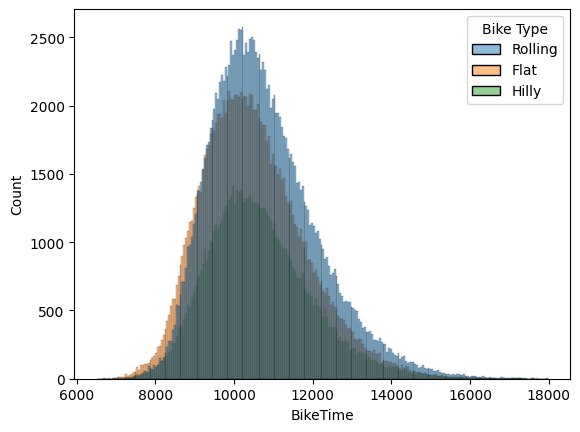

In [37]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.histplot(data=df_merged, x='BikeTime', hue='Bike Type', palette='tab10')
plt.show()

C:\Users\emartin4\AppData\Local\Temp\ipykernel_15864\3614987516.py:4: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(data=df_merged, x='SwimTime', palette='tab10', label='SwimTime')
C:\Users\emartin4\AppData\Local\Temp\ipykernel_15864\3614987516.py:5: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(data=df_merged, x='BikeTime', palette='tab10', label='BikeTime')
C:\Users\emartin4\AppData\Local\Temp\ipykernel_15864\3614987516.py:6: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(data=df_merged, x='RunTime', palette='tab10', label='RunTime')


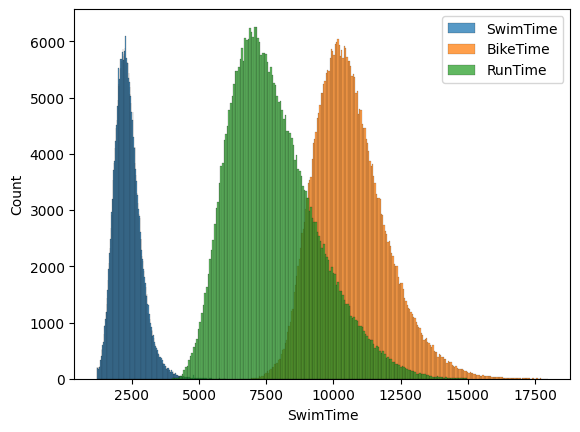

In [40]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.histplot(data=df_merged, x='SwimTime', palette='tab10', label='SwimTime')
sns.histplot(data=df_merged, x='BikeTime', palette='tab10', label='BikeTime')
sns.histplot(data=df_merged, x='RunTime', palette='tab10', label='RunTime')
plt.legend()
plt.show()

C:\Users\emartin4\AppData\Local\Temp\ipykernel_15864\3614987516.py:4: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(data=df_merged, x='SwimTime', palette='tab10', label='SwimTime')
C:\Users\emartin4\AppData\Local\Temp\ipykernel_15864\3614987516.py:5: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(data=df_merged, x='BikeTime', palette='tab10', label='BikeTime')
C:\Users\emartin4\AppData\Local\Temp\ipykernel_15864\3614987516.py:6: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(data=df_merged, x='RunTime', palette='tab10', label='RunTime')


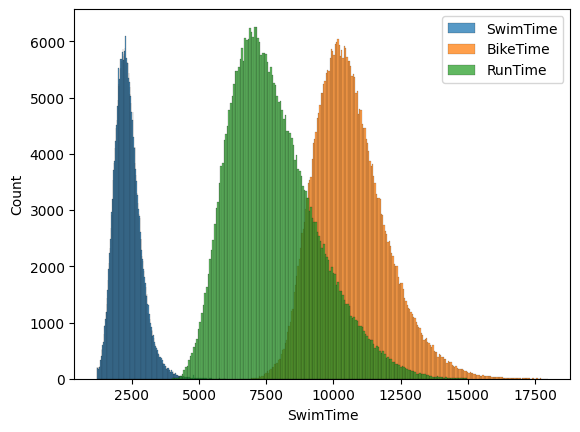

In [45]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.histplot(data=df_merged, x='SwimTime', palette='tab10', label='SwimTime')
sns.histplot(data=df_merged, x='BikeTime', palette='tab10', label='BikeTime')
sns.histplot(data=df_merged, x='RunTime', palette='tab10', label='RunTime')
plt.legend()
plt.show()

In [48]:
df_merged['FinishActiveTime'] = df_merged['RunTime'] + df_merged['SwimTime'] + df_merged['BikeTime']


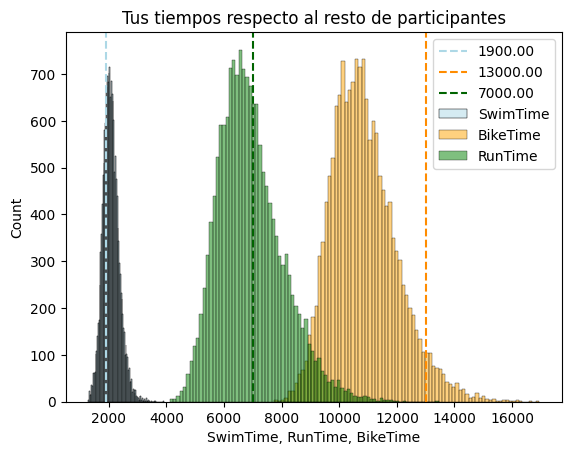

C:\Users\emartin4\AppData\Local\Temp\ipykernel_15864\386104599.py:18: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(data=df_merged[df_merged['EventLocation'] == 'IRONMAN 70.3 Mallorca'], x='FinishActiveTime', palette='tab10', label='FinishActiveTime')


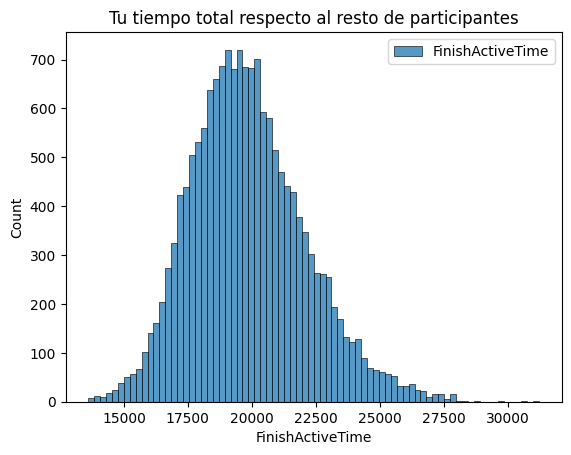

In [77]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.histplot(data=df_merged[df_merged['EventLocation'] == 'IRONMAN 70.3 Mallorca'], x='SwimTime',  color='lightblue', alpha=0.5, label='SwimTime')
swimtime=1900
plt.axvline(swimtime, color='lightblue', linestyle='--', label=f'{swimtime:.2f}')
biketime=13000
sns.histplot(data=df_merged[df_merged['EventLocation'] == 'IRONMAN 70.3 Mallorca'], x='BikeTime', color='orange', alpha=0.5, label='BikeTime')
plt.axvline(biketime, color='darkorange', linestyle='--', label=f'{biketime:.2f}')
runtime=7000
sns.histplot(data=df_merged[df_merged['EventLocation'] == 'IRONMAN 70.3 Mallorca'], x='RunTime', color='green', alpha=0.5, label='RunTime')
plt.axvline(runtime, color='darkgreen', linestyle='--', label=f'{runtime:.2f}')

plt.xlabel("SwimTime, RunTime, BikeTime")
plt.title("Tus tiempos respecto al resto de participantes")
plt.legend()
plt.show()
sns.histplot(data=df_merged[df_merged['EventLocation'] == 'IRONMAN 70.3 Mallorca'], x='FinishActiveTime', palette='tab10', label='FinishActiveTime')
plt.xlabel("SwimTime, RunTime, BikeTime")
plt.title("Tu tiempo total respecto al resto de participantes")
plt.xlabel("FinishActiveTime")

plt.legend()
plt.show()


In [ ]:
df_country_freqs = pd.read_csv("df_country_freqs.csv")
df_country_freqs

,Country,Frequency,Country_Encoded
0,United States,156625,0
1,Australia,31410,1
2,Canada,22458,2
3,Mexico,18835,3
4,Germany,14885,4
...,...,...,...
218,Djibouti,1,218
219,Christmas Island,1,219
220,Bouvet Island,1,220
221,Angola,1,221


In [ ]:
df_event_location_freq = pd.read_csv("df_event_location_freq.csv")
df_event_location_freq

,EventLocation,Frequency,EventLocation_Encoded
0,IRONMAN 70.3 Augusta,23803,0
1,IRONMAN 70.3 Florida,22576,1
2,IRONMAN 70.3 Texas,17168,2
3,IRONMAN 70.3 Eagleman,16618,3
4,IRONMAN 70.3 Mallorca,16307,4
...,...,...,...
63,IRONMAN 70.3 Waco,868,63
64,IRONMAN 70.3 San Juan / Puerto Rico,778,64
65,IRONMAN 70.3 Subic Bay,465,65
66,IRONMAN 70.3 Tallinn,452,66


In [ ]:
df_event_country_freq = pd.read_csv("df_event_country_freq.csv")
df_event_country_freq

,EventCountry,Frequency,EventCountry_Encoded
0,United States,167068,0
1,Australia,32332,1
2,Canada,21948,2
3,Mexico,21866,3
4,Spain,19061,4
5,Switzerland,13720,5
6,Brazil,9880,6
7,Poland,9265,7
8,Germany,9067,8
9,France,8757,9


In [ ]:
df_merge = pd.read_csv("df_merge_final.csv")

In [ ]:
df_country_of_location = df_merge[['EventCountry', 'EventLocation']].drop_duplicates().sort_values('EventCountry')
df_country_of_location

,EventCountry,EventLocation
184,Argentina,IRONMAN 70.3 Buenos Aires
27,Argentina,IRONMAN 70.3 San Juan
3770,Australia,IRONMAN 70.3 Cairns
123,Australia,IRONMAN 70.3 Port Macquarie
400,Australia,IRONMAN 70.3 Geelong
...,...,...
174,United States,IRONMAN 70.3 Maine
181,United States,IRONMAN 70.3 San Juan / Puerto Rico
224,United States,IRONMAN 70.3 Indian Wells La Quinta
7,Uruguay,IRONMAN 70.3 Punta del Este


In [ ]:
df_country_of_location[df_country_of_location['EventLocation'] == event]['EventCountry'].values[0]

'Spain'

In [ ]:
df_data

,Age,Elite,EventLocation,Gender,Country
0,27,True,IRONMAN 70.3 Mallorca,M,Spain


In [ ]:
df_event_country_freq

,EventCountry,Frequency,EventCountry_Encoded
0,United States,167068,0
1,Australia,32332,1
2,Canada,21948,2
3,Mexico,21866,3
4,Spain,19061,4
5,Switzerland,13720,5
6,Brazil,9880,6
7,Poland,9265,7
8,Germany,9067,8
9,France,8757,9


In [ ]:
df_data['Gender_M'] = df_data['Gender'].replace({"F": 0, "M": 1})
df_data = pd.merge(df_data, df_country_freqs[['Country', 'Country_Encoded']], on='Country', how='left')
df_data = pd.merge(df_data, df_event_location_freq[['EventLocation', 'EventLocation_Encoded']], on='EventLocation', how='left')
df_data['EventCountry'] = df_country_of_location[df_country_of_location['EventLocation'] == event]['EventCountry'].values[0]
df_data = pd.merge(df_data, df_event_country_freq[['EventCountry', 'EventCountry_Encoded']], on='EventCountry', how='left')


C:\Users\emartin4\AppData\Local\Temp\ipykernel_23852\10572739.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_data['Gender_M'] = df_data['Gender'].replace({"F": 0, "M": 1})


In [ ]:
import numpy as np
age_limits = [0, 18, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85]
age_groups = ['00', '18-24', '25-29', '30-34', '35-39', '40-44', '45-49', '50-54', '55-59', '60-64', '65-69', '70-74', '75-79', '80-84', '85-89']

def get_age_band_and_group(age):
    age_band = max([limit for limit in age_limits if limit <= age])
    idx = age_limits.index(age_band)
    age_group = age_groups[idx]
    
    return age_band, age_group

df_data[['AgeBand', 'AgeGroup']] = df_data['Age'].apply(lambda age: pd.Series(get_age_band_and_group(age)))


In [ ]:
df_filter = df_merge[['Country','Location', 'Swim Type', 'Bike Type', 'Run Type', 'Latitude', 'Longitude', 'Altitude (m)', 'Air Temperature (°C)', 'Water Temperature (°C)', 'EventCountry', 'Distance from Country Center (km)', 'Distance from Country Center (m)', 'EventLocation']].drop_duplicates()
# df_filter.rename(columns = {'EventLocation': 'EventLocation_Encoded'}, inplace=True)

df_filter

,Country,Location,Swim Type,Bike Type,Run Type,Latitude,Longitude,Altitude (m),Air Temperature (°C),Water Temperature (°C),EventCountry,Distance from Country Center (km),Distance from Country Center (m),EventLocation
0,Andorra,"Victoria, British Columbia",Lake,Rolling,Flat,48.428318,-123.364953,23,18,19,Canada,8579.704532,8.579705e+06,IRONMAN 70.3 Victoria
1,Andorra,"Santa Cruz, California",Ocean,Rolling,Flat,37.050096,-121.990590,11,18,17,United States,9505.490221,9.505490e+06,IRONMAN 70.3 Santa Cruz
2,Andorra,"Galveston, Texas",Ocean,Flat,Rolling,29.387225,-94.992736,2,21,22,United States,8360.097393,8.360097e+06,IRONMAN 70.3 Texas
3,Andorra,"Alcúdia, Mallorca, Spain",Ocean,Hilly,Flat,39.852193,3.118502,10,25,17,Spain,325.489516,3.254895e+05,IRONMAN 70.3 Mallorca
4,Andorra,"Vichy, France",Lake,Hilly,Flat,46.123927,3.420371,252,28,25,France,424.510467,4.245105e+05,IRONMAN 70.3 Vichy
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
383489,Zimbabwe,"Panama City Beach, Florida",Ocean,Flat,Flat,30.176591,-85.805386,2,26,22,United States,13442.355752,1.344236e+07,IRONMAN 70.3 Gulf Coast
383490,Zimbabwe,"Chattanooga, Tennessee",River,Rolling,Rolling,35.045722,-85.309488,210,22,22,United States,13424.475251,1.342448e+07,IRONMAN 70.3 Chattanooga
383498,Zimbabwe,"Boise, Idaho",Reservoir,Rolling,Flat,43.616616,-116.200886,820,27,22,United States,15785.331772,1.578533e+07,IRONMAN 70.3 Boise
383499,Zimbabwe,"San Juan, Argentina",Reservoir,Hilly,Flat,-30.705436,-69.198822,598,25,20,Argentina,9800.804073,9.800804e+06,IRONMAN 70.3 San Juan


In [ ]:
df_model = pd.merge(df_data, df_filter, on=['EventLocation', 'Country', 'EventCountry'], how='inner')
df_model

,Age,Elite,EventLocation,Gender,Country,Gender_M,Country_Encoded,EventLocation_Encoded,EventCountry,EventCountry_Encoded,...,Swim Type,Bike Type,Run Type,Latitude,Longitude,Altitude (m),Air Temperature (°C),Water Temperature (°C),Distance from Country Center (km),Distance from Country Center (m)
0,27,True,IRONMAN 70.3 Mallorca,M,Spain,1,18,4,Spain,4,...,Ocean,Hilly,Flat,39.852193,3.118502,10,25,17,685.751053,685751.052848


In [ ]:
df_types_per_location = pd.read_csv('df_types_per_location.csv')
df_types_per_location = df_types_per_location.drop(columns=['Unnamed: 0'], errors='ignore')
df_types_per_location

,EventLocation_Encoded,Run Type_Flat,Run Type_Hilly,Run Type_Rolling,Swim Type_Bay,Swim Type_Lake,Swim Type_Ocean,Swim Type_Reservoir,Swim Type_River,Bike Type_Flat,Bike Type_Hilly,Bike Type_Rolling
0,0,1,0,0,0,0,0,0,1,0,0,1
1,1,0,0,1,0,1,0,0,0,0,0,1
2,2,0,0,1,0,0,1,0,0,1,0,0
3,3,1,0,0,0,0,0,0,1,1,0,0
4,4,1,0,0,0,0,1,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...
63,63,0,0,1,0,0,0,0,1,1,0,0
64,64,0,1,0,1,0,0,0,0,1,0,0
65,65,0,0,1,0,0,1,0,0,1,0,0
66,66,1,0,0,1,0,0,0,0,1,0,0


In [ ]:
df_model = pd.merge(df_model, df_types_per_location, on='EventLocation_Encoded', how='inner')
df_model

,Age,Elite,EventLocation,Gender,Country,Gender_M,Country_Encoded,EventLocation_Encoded,EventCountry,EventCountry_Encoded,...,Run Type_Hilly,Run Type_Rolling,Swim Type_Bay,Swim Type_Lake,Swim Type_Ocean,Swim Type_Reservoir,Swim Type_River,Bike Type_Flat,Bike Type_Hilly,Bike Type_Rolling
0,27,True,IRONMAN 70.3 Mallorca,M,Spain,1,18,4,Spain,4,...,0,0,0,0,1,0,0,0,1,0


In [ ]:
df_model['Is_Local'] = (df_model['Country'] == df_model['EventCountry']).astype(int)
df_model

,Age,Elite,EventLocation,Gender,Country,Gender_M,Country_Encoded,EventLocation_Encoded,EventCountry,EventCountry_Encoded,...,Run Type_Rolling,Swim Type_Bay,Swim Type_Lake,Swim Type_Ocean,Swim Type_Reservoir,Swim Type_River,Bike Type_Flat,Bike Type_Hilly,Bike Type_Rolling,Is_Local
0,27,True,IRONMAN 70.3 Mallorca,M,Spain,1,18,4,Spain,4,...,0,0,0,1,0,0,0,1,0,1
